In [576]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.collections import LineCollection
from datetime import date, timedelta
from tqdm import notebook,trange
plt.style.use('seaborn')


SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [577]:
catches_df = pd.read_hdf('catches.h5',key='catches')
catches_df = catches_df.sort_values(by="Datetime")
rats_df = catches_df[catches_df["Species caught"] == "Rat"]
rats_groups = rats_df["Community Group"].unique()
rats_groups = np.sort(rats_groups)
possums_df = catches_df[catches_df["Species caught"] == "Possum"]
possums_groups = possums_df["Community Group"].unique()
possums_groups = np.sort(possums_groups)

<H2> Catch Distribution </H2>
How are catches distributed between active traps?

In [578]:
def plot_catch_distribution(df, title=""):
    """
    Plot the cummulative number of catches per trap as a %, ordered by number of catches for the 
    data in "df"
    
    """
    
    trap_df = df.groupby(by="Number/Code").count()
    trap_df = trap_df.sort_values(by="Datetime", ascending=False)
    counts = np.array(trap_df["Datetime"])
    cum_counts = np.cumsum(counts)
    counts_perc = cum_counts/np.max(cum_counts)*100.
    trap_idx = np.arange(1,len(counts_perc)+1)
    traps_perc = trap_idx/np.max(trap_idx) * 100.
    
    # Locate indices for 25%, 50% and 75%
    idx_25 = np.argmax(counts_perc > 25 )
    idx_50 = np.argmax(counts_perc > 50 )
    idx_75 = np.argmax(counts_perc > 75)
    
    fig = plt.figure(2,figsize=(8,8))
    ax = fig.subplots(1)
    ax.set_xlabel("% Traps")
    ax.set_ylabel("% Catches")
    ax.set_title(title)
    
    ax.set_ylim(0,100)
    ax.set_xlim(0,100)
    l25_1 = [(0,25), (traps_perc[idx_25], 25)]
    l25_2 = [(traps_perc[idx_25],25), (traps_perc[idx_25], 0)]
    l50_1 = [(0,50), (traps_perc[idx_50], 50)]
    l50_2 = [(traps_perc[idx_50],50), (traps_perc[idx_50], 0)]
    l75_1 = [(0,75), (traps_perc[idx_75], 75)]
    l75_2 = [(traps_perc[idx_75],75), (traps_perc[idx_75], 0)]
    lc = LineCollection([l25_1,l25_2, l50_1,l50_2,l75_1,l75_2], color="#AA2222", lw=1)
    plt.gca().add_collection(lc)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(25))
    ax.plot(traps_perc,counts_perc, linewidth=3, color="#5533AA")
   
    ax.set_xticks([traps_perc[idx_25],traps_perc[idx_50],traps_perc[idx_75] ], minor=True)
    idx = [idx_25,idx_50,idx_75]
    idx_labels = ["{:.1f}".format(traps_perc[ix]) for ix in idx ]
    ax.set_xticklabels(idx_labels, minor=True)
    
    

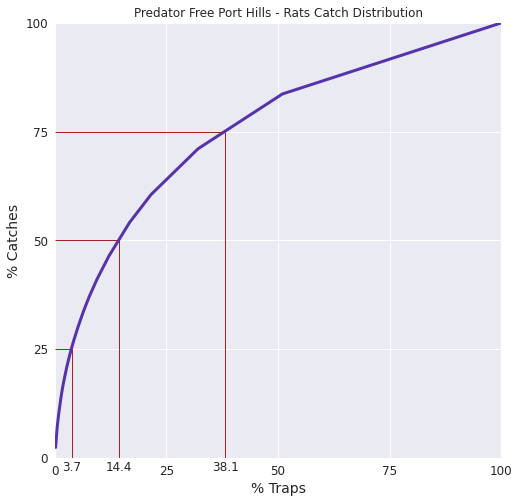

In [579]:
plot_catch_distribution(rats_df,title="Predator Free Port Hills - Rats Catch Distribution")


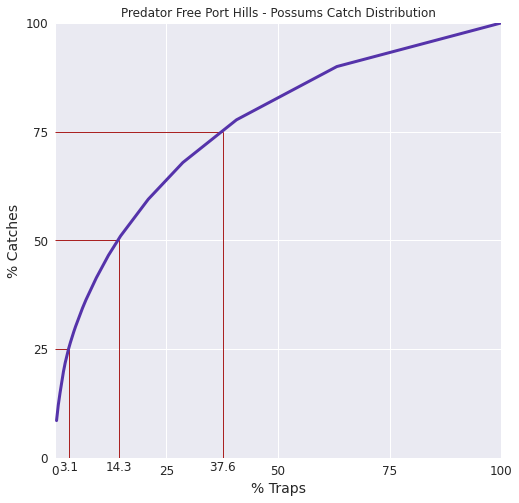

In [580]:
plot_catch_distribution(possums_df,title="Predator Free Port Hills - Possums Catch Distribution")


<H2> Temporal Distribution of Catches </H2>
Over what time did the most active traps get their catches?

In [581]:
def plot_temporal_distibution(df, min_num_catches = 5, title=""):
    """
    
    
    """
    def assign_catches_to_mat(dt,trap_name, mat, start_date, trap_to_idx):
        day = dt.date()
        day_idx = int((day-start_date)/timedelta(days=1))
        if trap_name in trap_to_idx:
            trap_idx=trap_to_idx[trap_name]
            mat[day_idx,trap_idx] = trap_idx+1
            # Thicken the lines a bit artificially
            if day_idx != 0:
                mat[day_idx-1,trap_idx] = trap_idx+1
            if day_idx != mat.shape[0]:
                mat[day_idx+1,trap_idx] = trap_idx+1
        
        
    # Create a dataframe grouped by day - index will be days
    counts_by_day_df = df.groupby(by=df['Datetime'].dt.date).count()
    days = np.array(counts_by_day_df.index)
    days_len = int((days[-1] - days[0])/timedelta(days=1)) +1
    counts_by_trap_df = df.groupby(by=df['Number/Code']).count()
    counts_by_trap_df = counts_by_trap_df[counts_by_trap_df['Species caught'] > min_num_catches]
    counts_by_trap_df = counts_by_trap_df.sort_values(by='Species caught', ascending = False )
    counts = np.array(counts_by_trap_df["Species caught"])
    traps = np.array(counts_by_trap_df.index)

    # Add catches to trap name:
    trap_labels=[]
    for i in range(len(traps)):
        trap_labels.append("{} [{:2d}]".format(traps[i][:15],counts[i]))
    
    # Create the matrix:
    mat = np.zeros((days_len,len(traps)), dtype=np.int8)
    
    trap_to_idx = {}
    trap_to_idx = { traps[i] : i for i in range(len(traps))}
    
    earliest_date = days[0]
    
    # Iterate over the catches and assign each one of them to the matrix of catches:
    result=[assign_catches_to_mat(x,y, mat,earliest_date, trap_to_idx) for x,y in zip(df['Datetime'],df['Number/Code']) ]
    
    fig = plt.figure(2,figsize=(15,10))
    ax = fig.subplots(1)
    ax.set_yticks([x for x in range(len(traps))])
    ax.set_yticklabels(traps)
   
    # mask some 'bad' data, in your case you would have: data == 0
    mat = np.ma.masked_where(mat < 0.05, mat)

    
    cmap = plt.cm.get_cmap("tab20").copy()

    cmap.set_bad(color='black')
    xlims = [days[0],days[-1]]
    xlims =  mdates.date2num(xlims)
    ax.imshow(mat.T, aspect='auto', interpolation='none', cmap=cmap, extent=[xlims[0],xlims[1],len(traps),0])
    ax.grid(False, axis="y")
    ax.grid(True,axis="x", linewidth=0.5,c="#DDDDDD")
    ax.set_title(title)
    ax.set_ylabel("Trap Name")
    ax.set_xlabel("Date")
    ax.xaxis_date()
    date_format = mdates.DateFormatter('%h-%y')
    ax.yaxis.set(ticks=np.arange(0.5, len(traps)), ticklabels=trap_labels)
    ax.xaxis.set_major_formatter(date_format)

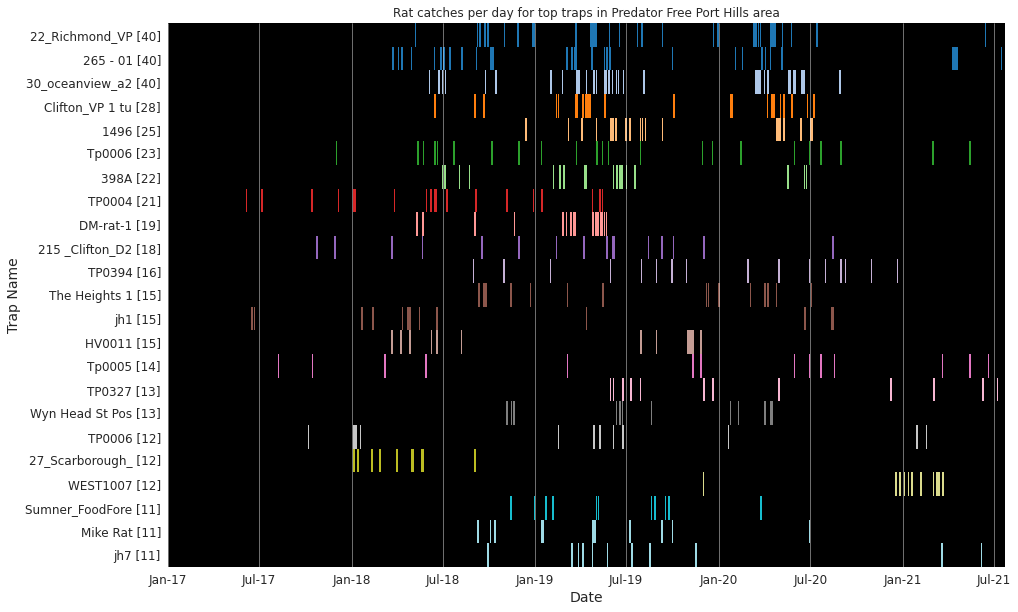

In [582]:
plot_temporal_distibution(rats_df, min_num_catches = 10,
                          title="Rat catches per day for top traps in Predator Free Port Hills area")

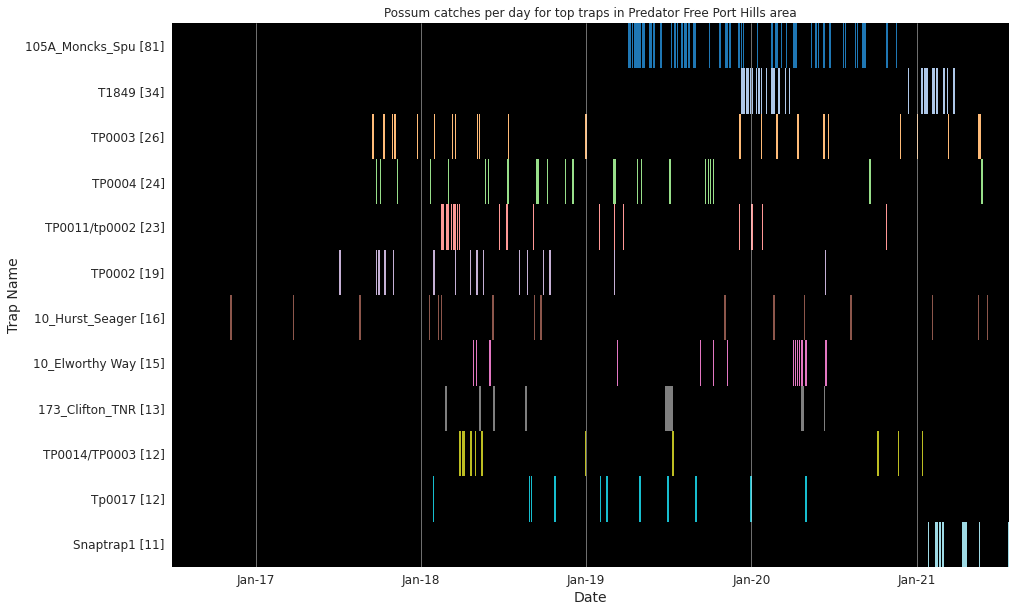

In [583]:
plot_temporal_distibution(possums_df,min_num_catches=10,
                          title="Possum catches per day for top traps in Predator Free Port Hills area")

<H2> Catches Per Trap </H2>

In [584]:
def plot_catches_per_group(df, groups, title="" ):
    """
    Plot cummulative catches over time for each group named in "groups" from dataframe "df"
    
    Returns a dict of tuples: {groupname: (dates,catches)}
    """
    fig = plt.figure(2,figsize=(12,8))
    ax = fig.subplots(1)
    n = len(groups)
    colors = plt.cm.tab20(np.linspace(0,1,n))

    catches_per_group = {}
    for i,g in enumerate(groups):
        group_df = df[df["Community Group"] == g]
        catches_by_day_df = group_df.groupby(by=group_df['Datetime'].dt.date).count()
        catches_by_day = np.array(catches_by_day_df["Species caught"])
        catches_by_day = np.cumsum(catches_by_day)
        dates = (np.array(catches_by_day_df.index))
        ax.plot(dates, catches_by_day, label=g,lw=3, c=colors[i])
        catches_per_group[g] = (dates, catches_by_day)
       
    ax.set_xlabel("Date")
    ax.set_ylabel("Cummulative Catches")
    ax.set_title(title)
    ax.legend()
    
    return catches_per_group
    

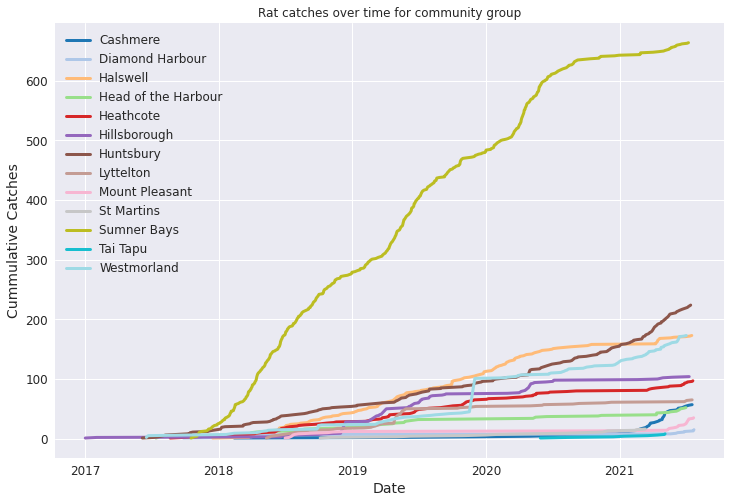

In [585]:
rats_catches_per_group = plot_catches_per_group(rats_df, rats_groups, title="Rat catches over time for community group")

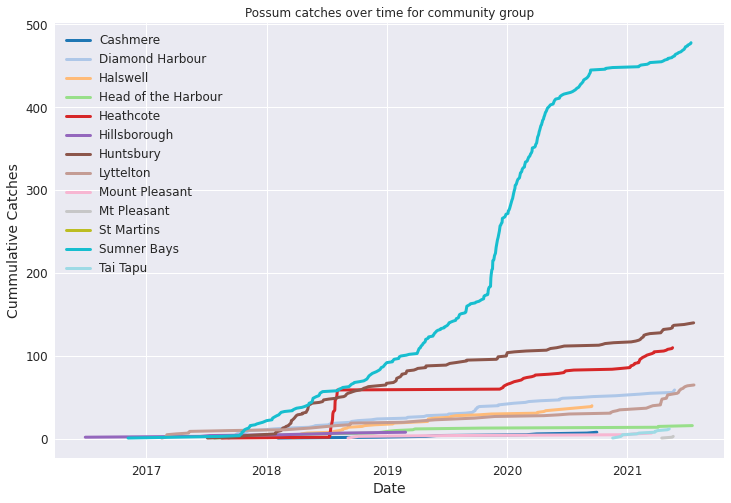

In [586]:
possums_catches_per_group = plot_catches_per_group(possums_df, possums_groups, title="Possum catches over time for community group")

In [587]:
def plot_traps_per_group(df, groups, title=""):
    """
    Plot cummulative unique traps over time for each group named in "groups" from dataframe "df"
    
    Returns a dict of tuples: {groupname: (dates,traps)}
    """
    
    fig = plt.figure(2,figsize=(12,8))
    ax = fig.subplots(1)
    n = len(groups)
    colors = plt.cm.tab20(np.linspace(0,1,n))

    traps_per_group = {}
    for i,g in enumerate(groups):
        group_df = df[df["Community Group"] == g]
        traps_per_group_ser = (group_df.drop_duplicates(['Number/Code'])
           .groupby(by=group_df['Datetime'].dt.date)
           .size().cumsum()
           .reindex(group_df['Datetime'].dt.date.unique())
           .ffill()
        )
        dates = np.array(traps_per_group_ser.keys())
        traps_by_day = traps_per_group_ser.to_numpy()
        ax.plot(dates, traps_by_day, label=g,lw=3, c=colors[i])
        traps_per_group[g] = (dates, traps_by_day)
       
    ax.set_xlabel("Date")
    ax.set_ylabel("Cummulative Traps")
    ax.set_title(title)
    ax.legend()
    
    return traps_per_group

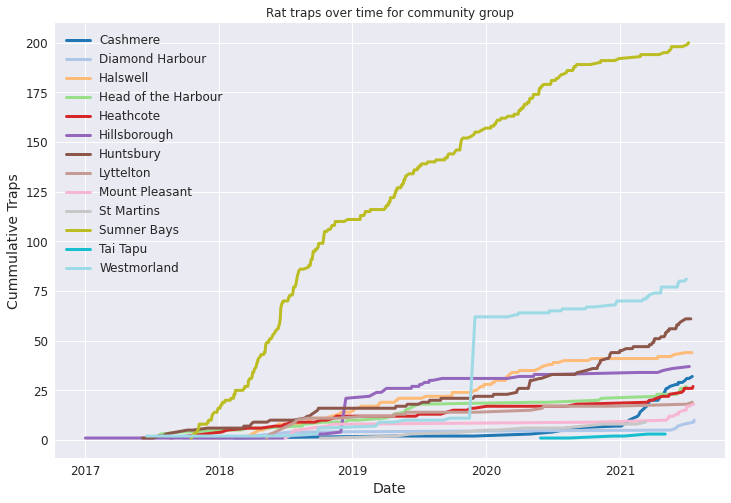

In [588]:
rats_traps_per_group = plot_traps_per_group(rats_df, rats_groups, title="Rat traps over time for community group")

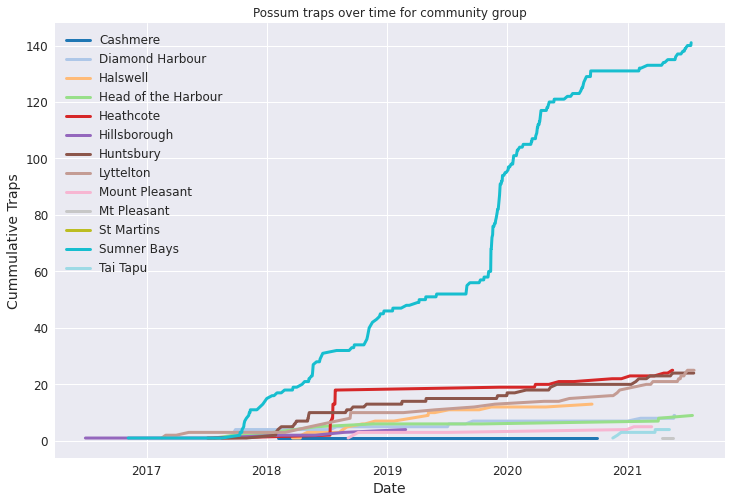

In [589]:
possums_traps_per_group = plot_traps_per_group(possums_df, possums_groups, title="Possum traps over time for community group")

In [590]:
def plot_catches_per_trap_for_groups(df, groups, catches_per_group,traps_per_group, title=""):
    """
    Plot catches per traps for each group using dictionaries catches_per_group and traps_per_group
    
    """
    fig = plt.figure(2,figsize=(12,8))
    ax = fig.subplots(1)
    n = len(groups)
    colors = plt.cm.tab20(np.linspace(0,1,n))

    for i,g in enumerate(groups):
        
        catches_per_trap = catches_per_group[g][1]/traps_per_group[g][1]
        dates = catches_per_group[g][0]
        ax.plot(dates, catches_per_trap, label=g,lw=3, c=colors[i])
        
       
    ax.set_xlabel("Date")
    ax.set_ylabel("Catches per trap")
    ax.set_title(title)
    ax.legend()
    
    

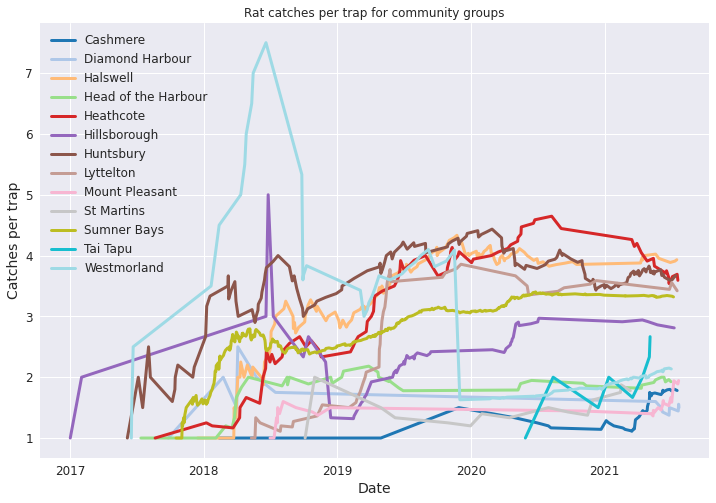

In [591]:
plot_catches_per_trap_for_groups(rats_df, rats_groups, rats_catches_per_group, rats_traps_per_group, title="Rat catches per trap for community groups")

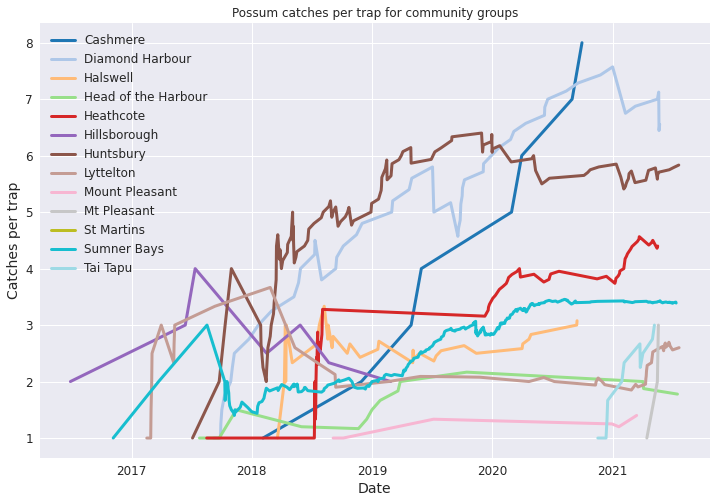

In [592]:
plot_catches_per_trap_for_groups(possums_df, possums_groups, possums_catches_per_group, possums_traps_per_group,
                                 title="Possum catches per trap for community groups")